In [1]:
import pandas as pd
import geopandas as gpd
import movingpandas as mpd
import numpy as np
from datetime import timedelta, datetime
import folium
import time
import warnings
import pickle
import sys
warnings.filterwarnings('ignore')
print("Geopandas has version {}".format(gpd.__version__))
print("Movingpandas has version {}".format(mpd.__version__))

Geopandas has version 0.13.2
Movingpandas has version 0.17.1


In [2]:
# add paths for modules
sys.path.append('../models')
sys.path.append('../visualization')
# import modules
import visualize
from maritime_traffic_network import MaritimeTrafficNetwork

In [3]:
datasize = 'full'
location = 'stavanger'
data_date = '202204'
eval_date = '202204'

# load network from pickle
model = data_date+'_waypoints_DP10_HDBSCAN16_'+location+'_'+datasize+'_UTM'
model_path = '../../models/networks/best_networks/' + model + '.obj'
fileObj = open(model_path, 'rb')
network = pickle.load(fileObj)
fileObj.close()
network.hyperparameters

{'Data': '../../data/processed/202204_points_stavanger_cleaned_meta_full_dualSplit_2.parquet',
 'DP_tolerance': 10,
 'clustering_method': 'HDBSCAN',
 'clustering_metric': 'mahalanobis',
 'clustering_min_samples': 16,
 'clustering_min_cluster_size': 16,
 'clustering_eps': 0,
 'clustering_metric_V': array([[1.  , 0.  , 0.  , 0.  , 0.  ],
        [0.  , 1.  , 0.  , 0.  , 0.  ],
        [0.  , 0.  , 0.01, 0.  , 0.  ],
        [0.  , 0.  , 0.  , 0.01, 0.  ],
        [0.  , 0.  , 0.  , 0.  , 1.  ]]),
 'graph_generation_max_distance': 20,
 'graph_generation_max_angle': 45}

In [4]:
# load evaluation data
eval_file = eval_date+'_points_'+location+'_cleaned_meta_full_dualSplit_2'
filename = '../../data/processed/' + eval_file + '.parquet'
test_gdf = gpd.read_parquet(filename)
crs = 32632  # Coordinate reference system
test_gdf.to_crs(crs, inplace=True)  # Transformation
all_test_trajectories = mpd.TrajectoryCollection(test_gdf, traj_id_col='mmsi', obj_id_col='mmsi')

# select evaluation data
selection_start = 0
selection_end = len(all_test_trajectories)
selection_step = 1
selection = np.arange(selection_start, selection_end, selection_step)
n_trajectories = len(selection)
mmsis = test_gdf.mmsi.unique()[selection]
test_trajectories = all_test_trajectories.filter('mmsi', mmsis.tolist())

In [5]:
# merge stop points
network.merge_stop_points(max_speed=2)
network.prune_graph(1)

Pruning...
------------------------
Pruned Graph:
Number of nodes: 2241 (20 isolated)
Number of edges: 12301
------------------------


Evaluating graph on 14375 trajectories
Progress: 10%...20%...30%...40%...50%...60%...70%...80%...90%...Done! Time elapsed for evaluation: 2009.64 minutes
Success rates:
                   mmsi      SSPD  distances  fraction_covered      path  path_linestring
message                                                                                  
attempt        0.011687  0.011687   0.011687          0.011687  0.011687         0.011687
no_intersects  0.070261  0.000000   0.000000          0.070261  0.000000         0.000000
no_path        0.005565  0.000000   0.000000          0.005565  0.000000         0.000000
success        0.912487  0.912487   0.912487          0.912487  0.912487         0.912487

 --------------------------- 

Fraction of NaN results: 0.076

 --------------------------- 

Mean fraction of each trajectory covered by the path on the graph: 0.903 

Mean distance      = 222.96 m
Median distance    = 85.23 m
Standard deviation = 494.44 m 



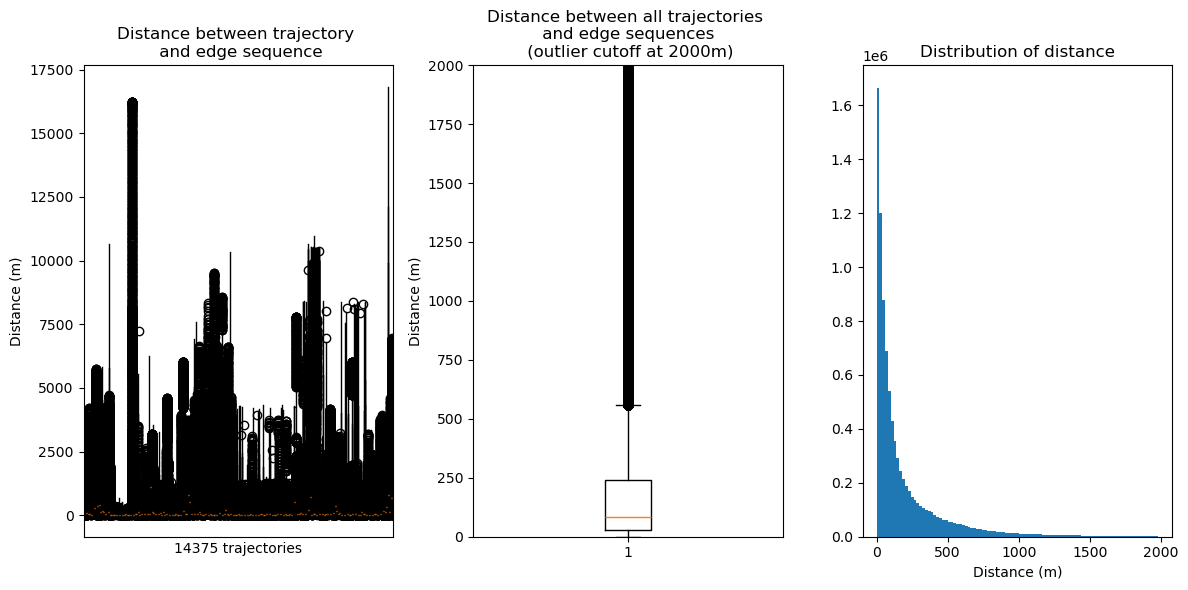

In [6]:
# evaluate all trajectories on the current network to create a training dataset for this specific network
all_paths, all_evaluation_results, summary, fig = network.evaluate_graph(test_trajectories)

In [7]:
all_evaluation_results

,mmsi,SSPD,distances,fraction_covered,message,path,path_linestring
0,205209000_0_2022-04-08 03:12:48,221.521573,"[41.387339369325986, 36.59170775279303, 39.099...",0.996731,success,"[1606, 1624, 1630, 1670, 1671, 1615, 1622, 162...",LINESTRING (295457.6211042873 6620598.81204816...
0,205691000_0_2022-04-11 10:33:29,234.694683,"[10.854250393959283, 0.2952112068718813, 3.601...",0.733699,success,"[334, 1575, 1632, 1633, 1639, 1638, 1646, 1648...",LINESTRING (277583.26371358964 6540982.4952897...
0,205691000_18_2022-04-14 07:18:42,831.351295,"[1130.42413089043, 1073.539710519451, 1045.504...",0.661988,success,"[186, 290]",LINESTRING (307226.1984890706 6575839.88233479...
0,205691000_27_2022-04-15 12:03:35,86.928637,"[283.24052973326474, 280.98025900688367, 279.8...",0.593814,success,"[525, 524, 886, 1590, 1573, 1563, 1546, 1507, ...",LINESTRING (300378.74466953805 6575164.2829003...
0,205770000_0_2022-04-23 13:58:09,NaN,NaN,0.000000,no_intersects,NaN,NaN
...,...,...,...,...,...,...,...
0,566725000_9_2022-04-14 08:29:23,NaN,NaN,0.000000,no_intersects,NaN,NaN
0,636014908_0_2022-04-07 10:58:33,294.033681,"[62.203525819023795, 56.77704139689841, 49.682...",0.590499,success,"[398, 422, 424, 423, 475, 474]",LINESTRING (279460.9793509111 6498658.94660699...
0,636014908_0_2022-04-07 15:52:00,101.089518,"[97.83370369640593, 92.52128502735317, 90.0741...",0.294118,success,"[2034, 1988, 1983, 2104, 2123, 2135, 2136, 2102]",LINESTRING (299468.47057633154 6530393.4062091...
0,636014908_15_2022-04-08 19:10:57,30.889378,"[38.784601579522544, 23.38562477566648, 37.890...",0.577175,success,"[854, 48, 2045]",LINESTRING (303375.5159348029 6536282.58565948...


In [8]:
df = all_evaluation_results

In [9]:
# Filter out NaN results and bad examples
nan_mask = df.isna().any(axis=1)
df = df[~nan_mask]
#df = df[df['fraction_covered']>0.8]
#df = df[df['SSPD']<300]

In [10]:
# merge results with trajectory data and metadata
test_trajectories = test_trajectories.filter('mmsi', df['mmsi'].tolist())
traj_gdf = test_trajectories.to_traj_gdf()
merge_columns = ['mmsi', 'lengde', 'bredde', 'dypgaaende', 'skipstype', 'skipsgruppe']
test_gdf.drop_duplicates(subset=['mmsi'], inplace=True)
test_gdf.rename(columns={'length': 'lengde'}, inplace=True)
traj_gdf = traj_gdf.merge(test_gdf[merge_columns], on='mmsi', how='left')

merge_columns = ['mmsi', 'lengde', 'bredde', 'dypgaaende', 'skipstype', 'skipsgruppe', 'geometry']
df = df.merge(traj_gdf[merge_columns], on='mmsi', how='left')
df = gpd.GeoDataFrame(df)

In [11]:
df.to_csv(model+'_'+eval_date+'training_data.csv')

In [12]:
df.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 13285 entries, 0 to 13284
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   mmsi              13285 non-null  object  
 1   SSPD              13285 non-null  float64 
 2   distances         13285 non-null  object  
 3   fraction_covered  13285 non-null  float64 
 4   message           13285 non-null  object  
 5   path              13285 non-null  object  
 6   path_linestring   13285 non-null  object  
 7   lengde            13285 non-null  int64   
 8   bredde            10765 non-null  float64 
 9   dypgaaende        9801 non-null   float64 
 10  skipstype         10769 non-null  object  
 11  skipsgruppe       10769 non-null  object  
 12  geometry          13285 non-null  geometry
dtypes: float64(4), geometry(1), int64(1), object(7)
memory usage: 1.3+ MB
